# Data and Model

This notebook will show the data used, and how the model is created and trained.

In [1]:
import torch.nn as nn 
import torch
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from src import utils


# Useful function to convert tensors to numpy arrays
def to_np(x):
    return x.cpu().detach().numpy()
def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

## Data

For the data we use 1000 samples for both the training and testing data, drawn from the `make_moons` dataset from `scikit-learn`.  

/tmp/ipykernel_143175/2202713097.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


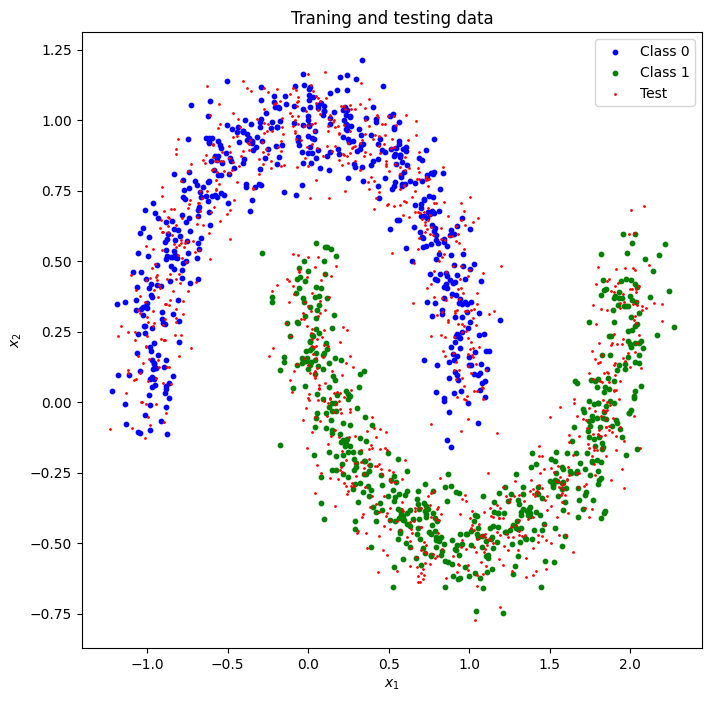

In [2]:
# Random seeds
training_seed = 42
test_seed = 78

# Generate training data
X_train, y_train = make_moons(n_samples=1000, noise=0.1, random_state=training_seed)
X_train, y_train = to_tensor(X_train), to_tensor(y_train)

# Generate test data with random data
X_test, y_test = make_moons(n_samples=1000, noise=0.1, random_state=test_seed)
X_test, y_test = to_tensor(X_test), to_tensor(y_test)

# Visualize data
fig, ax = plt.subplots(figsize=(8, 8))
class0 = y_train == 0
class1 = y_train == 1
training_scatter0 = ax.scatter(X_train[class0,0], X_train[class0,1], c='blue', s=10, label="Class 0")
training_scatter1 = ax.scatter(X_train[class1,0], X_train[class1,1], c='green', s=10, label="Class 1")

test_scatter = ax.scatter(X_test[:,0], X_test[:,1], c='r', s=1, label='Test')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.legend()
ax.set_title('Traning and testing data')
fig.show()

## Sample points from region

In order to compute the regions, we must feed some sample points throguht he model to log the activations. In order to not be biased towards any particular dataset, we sample $n^2$ points uniformly from the domain:


$$
{ (x_1, x_2) | x_1 \in \left[ \min(X_1) \cdot 1.1 , \max(X_1) \cdot 1.1 \right], x_2 \in \left[ \min(X_2) \cdot 1.1, \max(X_2) \cdot 1.1 \right] }
$$

/tmp/ipykernel_143175/3548551212.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


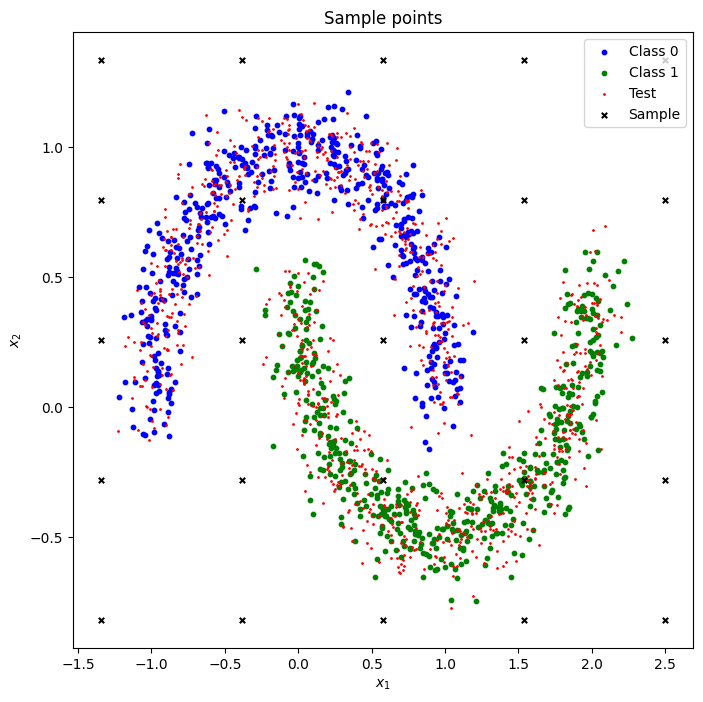

In [3]:
# Data points from which to sample the regions
bound_scale_factor = 1.1
boundsx1 = [to_np(X_train[:,0].min()*bound_scale_factor), to_np(X_train[:,0].max()*bound_scale_factor)]
boundsx2 = [to_np(X_train[:,1].min()*bound_scale_factor), to_np(X_train[:,1].max()*bound_scale_factor)]


n = 5 # Number of sampled points in each dimension. Total number of points: n**d
x_1 = np.linspace(boundsx1[0], boundsx1[1], n, dtype="float32")
x_2 = np.linspace(boundsx2[0], boundsx2[1], n, dtype="float32")
x_1, x_2 = np.meshgrid(x_1, x_2)
x_1 = np.reshape(x_1, (n**2,1))
x_2 = np.reshape(x_2, (n**2,1))
x_sample = np.concatenate((x_1,x_2), axis = 1)

# Visualize the samples
fig, ax = plt.subplots(figsize=(8, 8))
class0 = y_train == 0
class1 = y_train == 1
training_scatter0 = ax.scatter(X_train[class0,0], X_train[class0,1], c='blue', s=10, label="Class 0")
training_scatter1 = ax.scatter(X_train[class1,0], X_train[class1,1], c='green', s=10, label="Class 1")

test_scatter = ax.scatter(X_test[:,0], X_test[:,1], c='r', s=1, label='Test')
ax.set_title('Sample points')
ax.scatter(x_sample[:,0], x_sample[:,1], color='black', marker="x",s=15, label="Sample")
ax.legend()
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
fig.show()

In [4]:
# Check the shapes:
print(f"Shapes:\nTraining data: {X_train.shape}\nTraining labels: {y_test.shape}\nTesting data: {X_test.shape}\nTesting labels: {y_test.shape}\nSample points: {x_sample.shape}")

Shapes:
Training data: torch.Size([1000, 2])
Training labels: torch.Size([1000])
Testing data: torch.Size([1000, 2])
Testing labels: torch.Size([1000])
Sample points: (25, 2)


## Model

The model needs to be easy to visualize and not too complicated. Due to restrictions of the software that computes the regions, each layer must contain the same amount of neurons. Since this is a simple problem, we propose and architecture with six hidden layers, with 3 neurons each. The input is two-dimensional and the output one-dimensional. We use a standard SGD optimizer with learning rate $\gamma=0.01$ and momentum $\mu=0.1$. We then train the model for 15000 epochs, and save its weights and biases for each 500th epoch for later analysis.

In [5]:
# Model 
model = utils.NeuralNet(input_size = 2, num_classes = 1, hidden_sizes=[3,3,3,3,3,3])
model.train()
# Training params
EPOCHS = 15000
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.1)
# optimizer = torch.optim.Adam(model.parameters())
LOAD = False
save_everyth_epoch = 500
SAVE_STATES = False

In [6]:
# # Trains the data and save the state dictionaries
# train_loss, train_accuracy = [], []
# test_loss, test_accuracy = [], []
# for epoch in trange(EPOCHS):
#     model.train()
#     optimizer.zero_grad()
    
#     out = model(X_train)
#     loss = criterion(out, y_train.unsqueeze(1))
#     loss.backward()
#     train_loss.append(loss.item())
#     optimizer.step()
#     optimizer.zero_grad()
#     preds = torch.sigmoid(out) > 0.5
#     accuracy = (preds.squeeze() == y_train).float().mean().item()
#     train_accuracy.append(accuracy)
    
#     model.eval()
#     with torch.no_grad():
#         out = model(X_test)
#         loss = criterion(out, y_test.unsqueeze(1))
#         preds = torch.sigmoid(out) > 0.5
#         accuracy = (preds.squeeze() == y_test).float().mean().item()
#         test_loss.append(loss.item())
#         test_accuracy.append(accuracy)
#     if SAVE_STATES and (epoch % save_everyth_epoch == 0 or epoch == EPOCHS-1):
#         torch.save(model.state_dict(), f'../state_dicts/epoch{epoch}.pth')
    
# SAVE_STATES=False

# def save_array(_list, _path):
#     np.save(_path, np.asarray(_list))
    
    
# save_array(train_loss, '../state_dicts/train_loss.npy')
# save_array(test_loss, '../state_dicts/test_loss.npy')
# save_array(train_accuracy, '../state_dicts/train_accuracy.npy')
# save_array(test_accuracy, '../state_dicts/test_accuracy.npy')

In [7]:
# Loads saved training metrics.
train_loss = np.load('../state_dicts/train_loss.npy')
test_loss = np.load('../state_dicts/test_loss.npy')
train_accuracy = np.load('../state_dicts/train_accuracy.npy')
test_accuracy = np.load('../state_dicts/test_accuracy.npy')

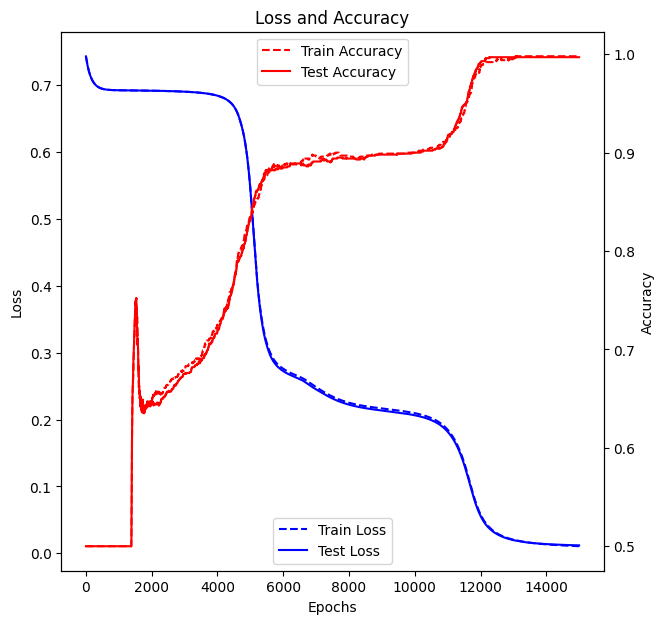

In [8]:
# Plot the training metrics.
fig, ax1 = plt.subplots(figsize=(7, 7))
ax1.plot(train_loss, label='Train Loss', ls='--', c='blue')
ax1.plot(test_loss, label='Test Loss', ls='-', c='blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss and Accuracy')
ax1.legend(loc="lower center")

ax2 = ax1.twinx()
ax2.plot(train_accuracy, label='Train Accuracy', ls='--', c='red')
ax2.plot(test_accuracy, label='Test Accuracy', ls='-', c='red')
ax2.set_ylabel('Accuracy')
ax2.legend(loc="upper center")
plt.show()

In [9]:
# Function to load a state dict
def load_from_state_dict(model, epoch):
    model.load_state_dict(torch.load(f'../state_dicts/epoch{epoch}.pth'))
    model.eval()

In [10]:
epochs = epochs = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 14999]

In [11]:
# Load and find test loss and test accuracy for the saved states to ensure consistend with the saved metrics. 
for epoch in epochs:
    load_from_state_dict(model, epoch)
    with torch.no_grad():
        out = model(X_test)
        loss = criterion(out, y_test.unsqueeze(1))
        preds = torch.sigmoid(out) > 0.5
        accuracy = (preds.squeeze() == y_test).float().mean().item()
        print(f"Epoch: {epoch}, loss: {loss:0.3f}, accuracy: {accuracy:0.3f}")

Epoch: 0, loss: 0.743, accuracy: 0.500
Epoch: 500, loss: 0.695, accuracy: 0.500
Epoch: 1000, loss: 0.692, accuracy: 0.500
Epoch: 1500, loss: 0.692, accuracy: 0.742
Epoch: 2000, loss: 0.692, accuracy: 0.647
Epoch: 2500, loss: 0.691, accuracy: 0.657
Epoch: 3000, loss: 0.690, accuracy: 0.675
Epoch: 3500, loss: 0.689, accuracy: 0.688
Epoch: 4000, loss: 0.684, accuracy: 0.719
Epoch: 4500, loss: 0.668, accuracy: 0.767
Epoch: 5000, loss: 0.545, accuracy: 0.832
Epoch: 5500, loss: 0.311, accuracy: 0.882
Epoch: 6000, loss: 0.272, accuracy: 0.885
Epoch: 6500, loss: 0.261, accuracy: 0.889
Epoch: 7000, loss: 0.245, accuracy: 0.891
Epoch: 7500, loss: 0.231, accuracy: 0.893
Epoch: 8000, loss: 0.222, accuracy: 0.894
Epoch: 8500, loss: 0.217, accuracy: 0.895
Epoch: 9000, loss: 0.213, accuracy: 0.898
Epoch: 9500, loss: 0.210, accuracy: 0.899
Epoch: 10000, loss: 0.206, accuracy: 0.900
Epoch: 10500, loss: 0.199, accuracy: 0.902
Epoch: 11000, loss: 0.182, accuracy: 0.916
Epoch: 11500, loss: 0.133, accuracy